## Colab: install deps

In [1]:
if 'google.colab' in str(get_ipython()):
    !yes | pip install git+https://github.com/mattclifford1/CLIME/ -qqq > /dev/null
%load_ext autoreload
%autoreload 2
import clime
from clime.utils.notebooks import *

# Pipeline for CLIME: Cost-sensitive LIME 

# Pipeline Options

In [2]:
data_store = get_pipeline_widgets()

CLASS SAMPLES (synthetic datasets):


interactive(children=(IntSlider(value=25, description='class_1', max=200, min=1), IntSlider(value=75, descript…

DATASET:


interactive(children=(Dropdown(description='x', options=('moons', 'guassian', 'credit scoring 1', 'credit scor…

DATASET REBALANCING:


interactive(children=(Dropdown(description='x', options=('none', 'oversampling'), value='none'), Output()), _d…

MODEL:


interactive(children=(Dropdown(description='x', options=('SVM', 'SVM balanced training'), value='SVM'), Output…

MODEL BALANCER:


interactive(children=(Dropdown(description='x', options=('boundary adjust', 'probability adjust', 'none'), val…

EXPLAINER:


interactive(children=(Dropdown(description='x', options=('bLIMEy (normal)', 'bLIMEy (cost sensitive training)'…

EVALUATION:


interactive(children=(Dropdown(description='x', options=('fidelity (normal)', 'fidelity (local)', 'fidelity (c…

# RUN

In [7]:
# run pipeline visulation 
get_run_button()

<IPython.core.display.Javascript object>

Button(description='RUN PIPELINE', style=ButtonStyle())

# Visualise

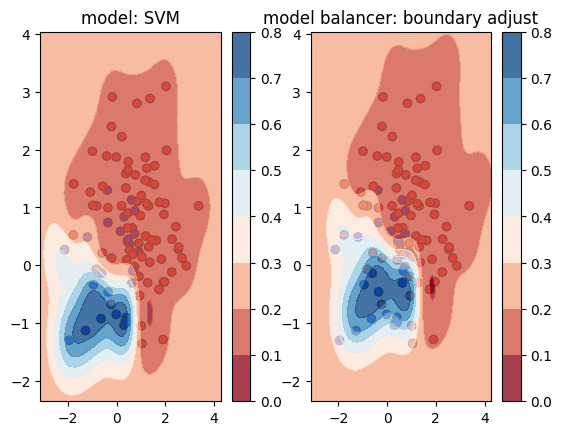

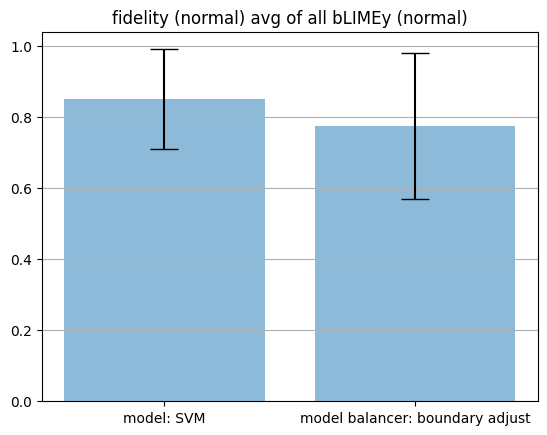

In [8]:
run_vis_pipeline(data_store)